# Setup imports and loader

In [1]:
import matplotlib.pyplot as plt
import incense
from common.helper.config import parseMongoConfig

loader = incense.ExperimentLoader(**parseMongoConfig('../config.ini', adapt='IncenseExperimentLoader'))

/home/jroeger/data/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Find failed Experiments, due to misconfiguration
The problem was, that pytorch does not support PerChannel activation quantization.

In [2]:
from collections import defaultdict


failed_query = {
    '$and': [
        {
            'experiment.name': 'PTSQ_CNN-IMU_LARa'
        },
        {
            'status': 'FAILED'
        },
        {
            '_id': {'$gte': 240}
        },
    ]
}
failed_experiments = loader.find(failed_query)

print(f'Found {len(failed_experiments)} failed Experiments')

exs_by_relevant_config_tuples = defaultdict(list)
for ex in failed_experiments:
  cfg = ex.to_dict()['config']
  exs_by_relevant_config_tuples[(cfg['activation_observer'], cfg['weight_observer'])].append(ex)

for (activation, weight), exs in exs_by_relevant_config_tuples.items():
  print(f'- activation = {activation}')
  print(f'  weight     = {weight}')
  for trace in set([ex.to_dict()["fail_trace"][-1] for ex in exs]):
    print(f'    {trace}',end='')

Found 180 failed Experiments
- activation = torch.ao.quantization.PerChannelMinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver
    RuntimeError: The size of tensor a (17) must match the size of tensor b (32) at non-singleton dimension 0
    ValueError: only one element tensors can be converted to Python scalars
- activation = torch.ao.quantization.PerChannelMinMaxObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
    RuntimeError: The size of tensor a (17) must match the size of tensor b (32) at non-singleton dimension 0
    ValueError: only one element tensors can be converted to Python scalars
- activation = torch.ao.quantization.MovingAveragePerChannelMinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver
    RuntimeError: The size of tensor a (17) must match the size of tensor b (32) at non-singleton dimension 0
    ValueError: only one element tensors can be converted to Python scalars
- activation = torch.ao.quantization.MovingAvera

## Confirm by checking all `COMPLETED` experiments
Exactly all PerTensor activation observers succeeded

In [3]:
completed_query = {
    '$and': [
        {
            'experiment.name': 'PTSQ_CNN-IMU_LARa'
        },
        {
            'status': 'COMPLETED'
        },
        {
            '_id': {
                '$gte': 241
            }
        },
    ]
}
completed_experiments = loader.find(completed_query)
print(f'There are {len(completed_experiments)} completed experiments')
observer_cfgs = [(e.to_dict()['config']['activation_observer'],
                  e.to_dict()['config']['weight_observer']) for e in completed_experiments]

print('Distinct observer combinations:')
for act, wgt in set(observer_cfgs):
  print(f'- activation = {act}')
  print(f'  weight     = {wgt}')


There are 270 completed experiments
Distinct observer combinations:
- activation = torch.ao.quantization.MinMaxObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
- activation = torch.ao.quantization.HistogramObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
- activation = torch.ao.quantization.MovingAverageMinMaxObserver
  weight     = torch.ao.quantization.PerChannelMinMaxObserver
- activation = torch.ao.quantization.HistogramObserver
  weight     = torch.ao.quantization.MinMaxObserver
- activation = torch.ao.quantization.MovingAverageMinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver
- activation = torch.ao.quantization.MinMaxObserver
  weight     = torch.ao.quantization.MinMaxObserver


# Best Quantization Results

In [4]:
best_wf1 = max(completed_experiments, key=lambda e: e.metrics['test/wf1'].max())

print(f'Best WF1 Scrore has Experiment {best_wf1.id}')
print(f'  Accuracy: {best_wf1.metrics["test/acc"].item()}')
print(f'  WF1:      {best_wf1.metrics["test/wf1"].item()}')
print(f'  Loss:     {best_wf1.metrics["test/loss"].mean()}')
print(f'Config: {best_wf1.to_dict()["config"]}')

Best WF1 Scrore has Experiment 296
  Accuracy: 0.7567296624183655
  WF1:      0.7431341409683228
  Loss:     0.6652039885520935
Config: {'trained_model_run_id': 225, 'activation_observer': 'torch.ao.quantization.MovingAverageMinMaxObserver', 'batch_size': 32, 'activation_qscheme': 'torch.per_tensor_affine', 'weight_observer_args': {'dtype': {'py/object': 'common.helper.qconfig_factory.GlobalPlaceholder', '_global_name': 'torch.qint8', '_kwargs': {}}, 'quant_max': 63, 'qscheme': {'py/object': 'common.helper.qconfig_factory.GlobalPlaceholder', '_global_name': 'torch.per_tensor_affine', '_kwargs': {}}, 'quant_min': -64}, 'n_bits': 7, 'weight_range': 'full', 'seed': 83224074, 'weight_qscheme': 'torch.per_tensor_affine', 'limit_calibration_set': 0.1, 'backend': 'fbgemm', 'activation_observer_args': {'dtype': {'py/object': 'common.helper.qconfig_factory.GlobalPlaceholder', '_global_name': 'torch.quint8', '_kwargs': {}}, 'quant_max': 127, 'qscheme': {'py/object': 'common.helper.qconfig_factor

# Best Quantization Results per Quantization Bitwidth

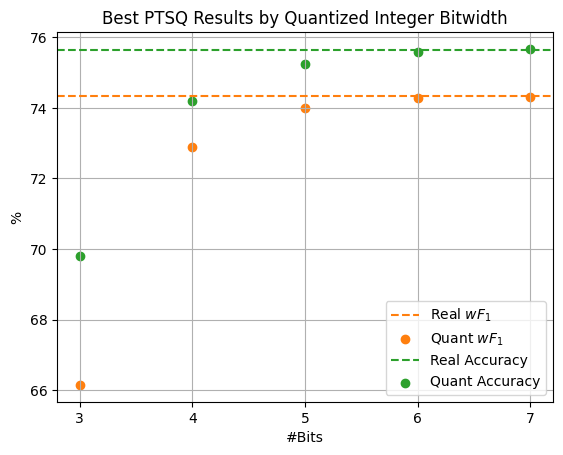

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm

experiments_by_bits = defaultdict(list)
for e in completed_experiments:
  experiments_by_bits[e.to_dict()['config']['n_bits']].append(e)

best_wf1_by_bits = {
    bits: max(exs, key=lambda e: e.metrics['test/wf1'].item())
    for bits, exs in experiments_by_bits.items()
}
base_experiments = loader.find_by_ids([e.to_dict()['config']['trained_model_run_id'] for e in best_wf1_by_bits.values()])
assert len(set(base_experiments)) == 1
base_experiment = base_experiments[0]

cmap=cm.get_cmap('tab10')
fig, ax = plt.subplots()
ax.axhline(y=base_experiment.metrics['test/wf1'].max()*100, color=cmap(1), label='Real $wF_1$', linestyle='dashed')
ax.scatter(x=list(best_wf1_by_bits.keys()), y=[e.metrics['test/wf1'].item()*100 for e in best_wf1_by_bits.values()], color=cmap(1), label='Quant $wF_1$')
ax.axhline(y=base_experiment.metrics['test/acc'].max()*100, color=cmap(2), label='Real Accuracy', linestyle='dashed')
ax.scatter(x=list(best_wf1_by_bits.keys()), y=[e.metrics['test/acc'].item()*100 for e in best_wf1_by_bits.values()], color=cmap(2), label='Quant Accuracy')
ax.grid(True)
ax.set_xticks(list(best_wf1_by_bits.keys()))
ax.set_xlabel('#Bits')
ax.set_ylabel('%')
ax.set_title('Best PTSQ Results by Quantized Integer Bitwidth')
ax.legend()
fig.show()

# Load best model weights by bits

In [6]:
from common.helper import checkpointsById
from common.model import CNNIMU
import logging

logging.disable(level=logging.WARN)
qmodel_best_wf1_by_bits = {
    bits: CNNIMU.load_from_checkpoint(
        checkpointsById('../logs/checkpoints',
                        ex.to_dict()['_id'])['model']) for bits, ex in best_wf1_by_bits.items()
}
fmodel_best_wf1_by_bits = {
    bits: CNNIMU.load_from_checkpoint(
        checkpointsById('../logs/checkpoints',
                        ex.to_dict()['config']['trained_model_run_id'])['best_wf1'])
    for bits, ex in best_wf1_by_bits.items()
}
logging.disable(level=logging.NOTSET)

[INF][torch.distributed.nn.jit.instantiator] Created a temporary directory at /tmp/tmpyu_3l0i9
[INF][torch.distributed.nn.jit.instantiator] Writing /tmp/tmpyu_3l0i9/_remote_module_non_scriptable.py
/home/jroeger/data/venv/lib/python3.9/site-packages/torch/ao/quantization/utils.py:287: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/home/jroeger/data/venv/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1204: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


# Groupwise Quantization Error

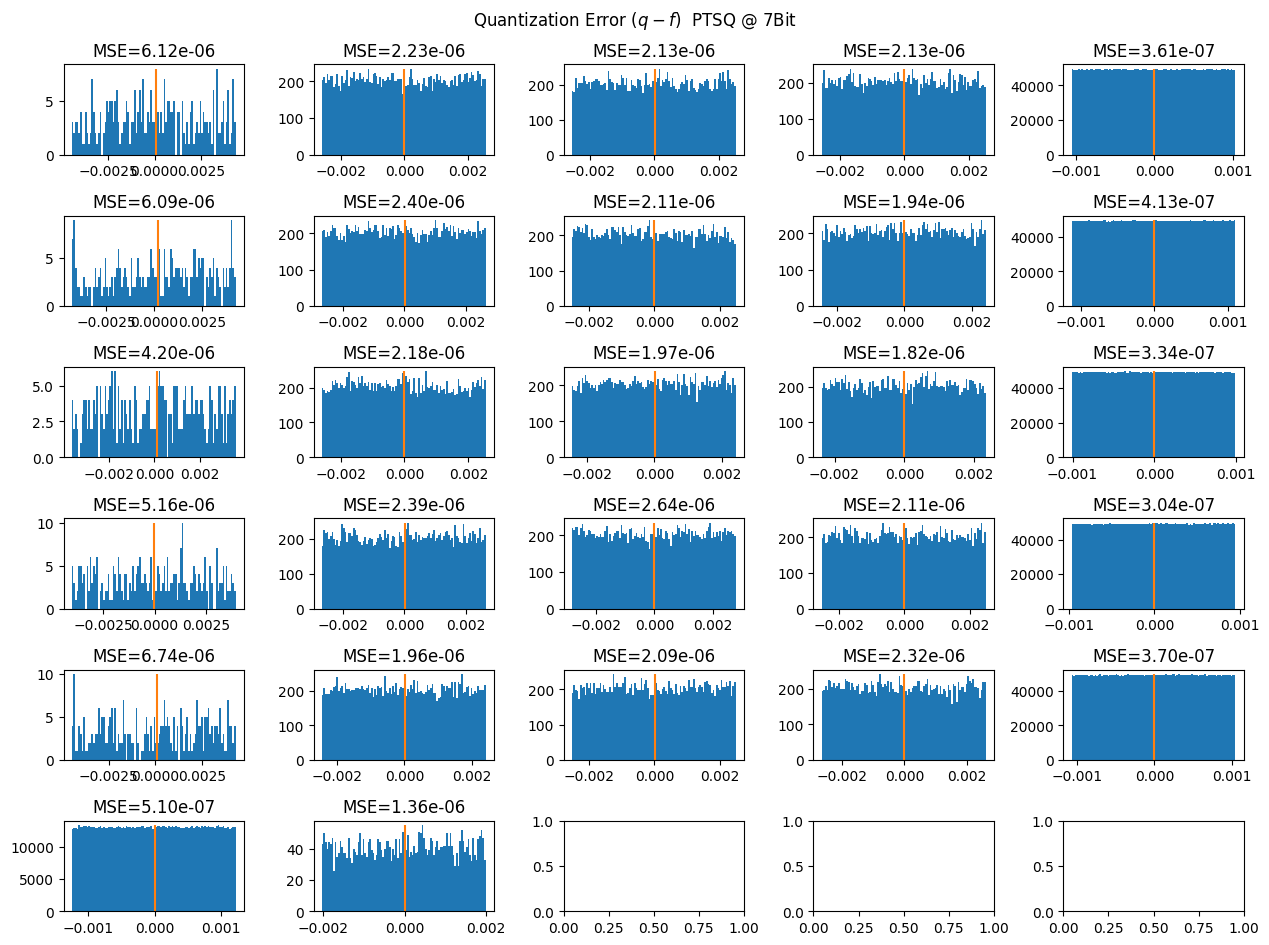

In [7]:
from common.eval.visualization import quantizedWeightHistogram, quantizationErrorHistorgram
from torch.ao.ns._numeric_suite import compare_weights
import torch

compare_dict_by_bits = {
    bits: compare_weights(float_dict=f.state_dict(), quantized_dict=q.state_dict())
    for (bits, f), (_, q) in zip(fmodel_best_wf1_by_bits.items(), qmodel_best_wf1_by_bits.items())
}

# calculate error
error_by_bits_by_key = defaultdict(dict)
for bits, cmp_dict in compare_dict_by_bits.items():
  for key, value in cmp_dict.items():
    fw = compare_dict_by_bits[bits][key]['float']
    qw = compare_dict_by_bits[bits][key]['quantized'].dequantize()
    error_by_bits_by_key[key][bits] = qw - fw

# create plot for each weight group
plot_bits = 7
fig, ax = plt.subplots(6, 5)
fig.suptitle(f'Quantization Error $(q - f)$  PTSQ @ {plot_bits}Bit')
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
for pipe_ix in range(5):
  weight_names = list(filter(lambda k: k.startswith(f'pipelines.{pipe_ix}'),
                              error_by_bits_by_key))
  weight_names.extend(
      list(filter(lambda k: k.startswith(f'pipe_fc.{pipe_ix}'), error_by_bits_by_key)))
  for w_ix, weight_name in enumerate(weight_names):
    quantizationErrorHistorgram(ax[pipe_ix][w_ix], error_by_bits_by_key[weight_name][plot_bits],
                                100, cmap)

for fc_ix, fc_name in enumerate(filter(lambda k: k.startswith('fc'), error_by_bits_by_key)):
  quantizationErrorHistorgram(ax[5][fc_ix], error_by_bits_by_key[fc_name][plot_bits], 100, cmap)
fig.tight_layout()


# Top n configurations by bits

In [8]:
from tabulate import tabulate
from common.eval.visualization import autoSortedRowTable


def fmtObserverConfig(ex):
  cfg = ex.to_dict()['config']
  act_args = cfg['activation_observer_args']
  act_obs = cfg['activation_observer'].split('.')[-1]
  wgt_obs = cfg['weight_observer'].split('.')[-1]
  wgt_args = cfg['weight_observer_args']
  return f'WF1={ex.metrics["test/wf1"].max():.03e}\n'\
        +f'Activation: {act_obs} [{act_args["quant_min"]}, {act_args["quant_max"]}]\n'\
        +f'Weight:     {wgt_obs} [{wgt_args["quant_min"]}, {wgt_args["quant_max"]}]'


def cfgIdentifier(ex):
  cfg = ex.to_dict()['config']
  return (cfg['activation_observer'], cfg['weight_observer'], cfg['weight_range'])


ex_wf1 = lambda e: e.metrics['test/wf1'].max()

top_n = 3

table_data = autoSortedRowTable(items=completed_experiments,
                                content_fn=fmtObserverConfig,
                                row_id_fn=lambda e: e.to_dict()['config']['n_bits'],
                                row_order_desc=True,
                                col_id_fn=cfgIdentifier,
                                col_ord_fn=ex_wf1,
                                col_ord_desc=True,
                                reduce_fn=lambda exs: max(exs, key=ex_wf1),
                                n_cols=top_n)
table_header = ['#Bits'] + [f'Top {n+1}' for n in range(top_n)]
tabulate(tabular_data=table_data, headers=table_header, tablefmt='html')

#Bits,Top 1,Top 2,Top 3
7,"WF1=7.431e-01 Activation: MovingAverageMinMaxObserver [0, 127] Weight: MinMaxObserver [-64, 63]","WF1=7.427e-01 Activation: MinMaxObserver [0, 127] Weight: MinMaxObserver [-64, 63]","WF1=7.426e-01 Activation: MovingAverageMinMaxObserver [0, 127] Weight: MinMaxObserver [-63, 63]"
6,"WF1=7.427e-01 Activation: MovingAverageMinMaxObserver [0, 63] Weight: PerChannelMinMaxObserver [-31, 31]","WF1=7.424e-01 Activation: MovingAverageMinMaxObserver [0, 63] Weight: PerChannelMinMaxObserver [-32, 31]","WF1=7.422e-01 Activation: HistogramObserver [0, 63] Weight: PerChannelMinMaxObserver [-31, 31]"
5,"WF1=7.399e-01 Activation: MovingAverageMinMaxObserver [0, 31] Weight: PerChannelMinMaxObserver [-15, 15]","WF1=7.394e-01 Activation: MovingAverageMinMaxObserver [0, 31] Weight: MinMaxObserver [-15, 15]","WF1=7.388e-01 Activation: MovingAverageMinMaxObserver [0, 31] Weight: PerChannelMinMaxObserver [-16, 15]"
4,"WF1=7.290e-01 Activation: MovingAverageMinMaxObserver [0, 15] Weight: PerChannelMinMaxObserver [-8, 7]","WF1=7.279e-01 Activation: MovingAverageMinMaxObserver [0, 15] Weight: MinMaxObserver [-8, 7]","WF1=7.259e-01 Activation: HistogramObserver [0, 15] Weight: PerChannelMinMaxObserver [-8, 7]"
3,"WF1=6.615e-01 Activation: HistogramObserver [0, 7] Weight: PerChannelMinMaxObserver [-3, 3]","WF1=6.582e-01 Activation: HistogramObserver [0, 7] Weight: PerChannelMinMaxObserver [-4, 3]","WF1=6.530e-01 Activation: MinMaxObserver [0, 7] Weight: PerChannelMinMaxObserver [-3, 3]"
